In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import seaborn as sns

In [2]:
# ddir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized'
# outdir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/GABAARs'
# !mkdir -p $outdir

In [3]:
def get_cond_from_biosample(sample):
    """
    """
    cond = sample[:-1]
    if not cond.endswith('DR'): 
        cond = cond+'NR'
        
    return cond

In [5]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/superdupermegaRNA_hasraw.h5ad'
adata_all = sc.read(f)

CPU times: user 3.79 s, sys: 18.8 s, total: 22.6 s
Wall time: 2min 41s


In [20]:
adata_all = adata_all[adata_all.obs['Study']=='2023 Multiome']
adata_all

View of AnnData object with n_obs × n_vars = 175418 × 16572
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden'
    var: 'feature_types'

In [21]:
print(adata_all.obs['Sample'].unique().astype(str))

['P6c' 'P6b' 'P6a' 'P8b' 'P8a' 'P8c' 'P10a' 'P10b' 'P12b' 'P12a' 'P12c'
 'P12DRa' 'P12DRb' 'P14b' 'P14a' 'P14DRb' 'P14DRa' 'P17a' 'P17b' 'P17DRb'
 'P17DRa' 'P21a' 'P21b' 'P21DRa' 'P21DRb']


In [22]:
adata_all.raw.X.shape

(175418, 16572)

In [23]:
y = adata_all.raw.X # this might NOT be the original count - but might be alright
y

<175418x16572 sparse matrix of type '<class 'numpy.float32'>'
	with 518675578 stored elements in Compressed Sparse Row format>

<Axes: ylabel='Count'>

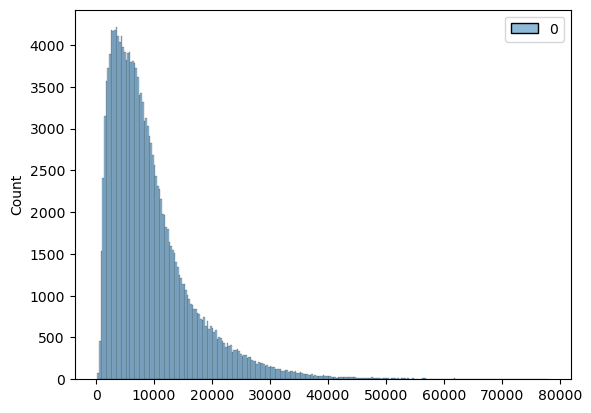

In [25]:
sns.histplot(y.sum(axis=1))

In [26]:
adata_all.obs['cond'] = adata_all.obs['Sample'].apply(lambda x: get_cond_from_biosample(x))
adata_all.obs['biosample'] = adata_all.obs['Sample']

/tmp/ipykernel_15269/2933899518.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_all.obs['cond'] = adata_all.obs['Sample'].apply(lambda x: get_cond_from_biosample(x))


In [27]:
unq_samples = natsort.natsorted(adata_all.obs['Sample'].unique())
print(len(unq_samples))
print(unq_samples) 

unq_conds   = natsort.natsorted(adata_all.obs['cond'].unique())
nf = len(unq_conds)
print(nf)
print(unq_conds)

25
['P6a', 'P6b', 'P6c', 'P8a', 'P8b', 'P8c', 'P10a', 'P10b', 'P12DRa', 'P12DRb', 'P12a', 'P12b', 'P12c', 'P14DRa', 'P14DRb', 'P14a', 'P14b', 'P17DRa', 'P17DRb', 'P17a', 'P17b', 'P21DRa', 'P21DRb', 'P21a', 'P21b']
11
['P6NR', 'P8NR', 'P10NR', 'P12DR', 'P12NR', 'P14DR', 'P14NR', 'P17DR', 'P17NR', 'P21DR', 'P21NR']


In [28]:
min_type = adata_all[adata_all.obs['cond']=='P21NR'].obs.groupby(['Subclass', 'Sample']).size().unstack().min(axis=1)
unq_types = min_type[min_type > 10].index.astype(str).values
unq_types

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Vip'], dtype=object)

In [29]:
### check size

# for i, f in enumerate(natsort.natsorted(glob.glob(ddir+'/*.h5ad'))):
    # print(f)
    # cond_name = os.path.basename(f)[:-len('.h5ad')]
    # adata = sc.read(f, backed='r')

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    
    adata = adata_all[adata_all.obs['cond']==cond_name]
    
    # check gene 
    if i == 0:
        genes = adata.var.index.values
    else:
        assert np.all(genes == adata.var.index.values)
        
    # check type
    unq_types_here = np.unique(adata.obs['Subclass'].values)
    assert len(np.intersect1d(unq_types, unq_types_here)) == len(unq_types)
        
    # check sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # check size
    nr, nc, ng =  len(unq_samples), len(unq_types), len(adata.var)  #  rep, subclass, gene 
    print(nr, nc, ng)
    

P6NR
3 18 16572
P8NR
3 18 16572
P10NR
2 18 16572
P12DR
2 18 16572
P12NR
3 18 16572
P14DR
2 18 16572
P14NR
2 18 16572
P17DR
2 18 16572
P17NR
2 18 16572
P21DR
2 18 16572
P21NR
2 18 16572


In [30]:
nf, nr, nc, ng

(11, 2, 18, 16572)

In [31]:
### read in the file and prep

nr = 3 # dummy for some
bigtensor = np.zeros((nf, nr, nc, ng))

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    
    adata = adata_all[adata_all.obs['cond']==cond_name]
        
    ### sum over counts 
    # by sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # by type
    type_lbls = adata.obs['Subclass'].values
    # unq_types = np.unique(type_lbls) # use global unq_types instead

    nr, nc, ng =  len(unq_samples), len(unq_types), len(adata.var)  #  rep, subclass, gene 

    for j, this_samp in enumerate(unq_samples):
        for k, this_type in enumerate(unq_types):
            selector = ((sample_lbls==this_samp) & (type_lbls==this_type))
            bigtensor[i,j,k] = np.sum(np.array(adata[selector].raw.X.todense()), axis=0) # raw reads sum over all cells
    
    if j < 2:
        bigtensor[i,2] = np.nan 
            
### CPM  - per cond, sample and subclass
# normalize it as log2(1+CPM)
bigtensor = (bigtensor/np.sum(bigtensor, axis=-1, keepdims=True))*1e6
bigtensor = np.log2(1+bigtensor) 

P6NR
P8NR
P10NR
P12DR
P12NR
P14DR
P14NR
P17DR
P17NR
P21DR
P21NR


In [32]:
output = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.npy' 
np.save(output, bigtensor)

In [33]:
output_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_subclass_v2.json' 
meta = {
    'size': bigtensor.shape,
    
    'dim0': list(unq_conds),
    'dim1': ['a', 'b', 'c'],
    'dim2': list(unq_types),
    'dim3': list(genes),
}

with open(output_meta, 'w') as fp:
    json.dump(meta, fp)

In [34]:
bigtensor = np.load(output)
bigtensor.shape

(11, 3, 18, 16572)

In [35]:
with open(output_meta, 'r') as fp:
    meta = json.load(fp)

# plot

In [36]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [37]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': 's',
            'DL': '^',
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.set_xticks(self.conds_time[sel])
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-k')

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color='k',
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [38]:
bo = Bigtensor(bigtensor, meta)

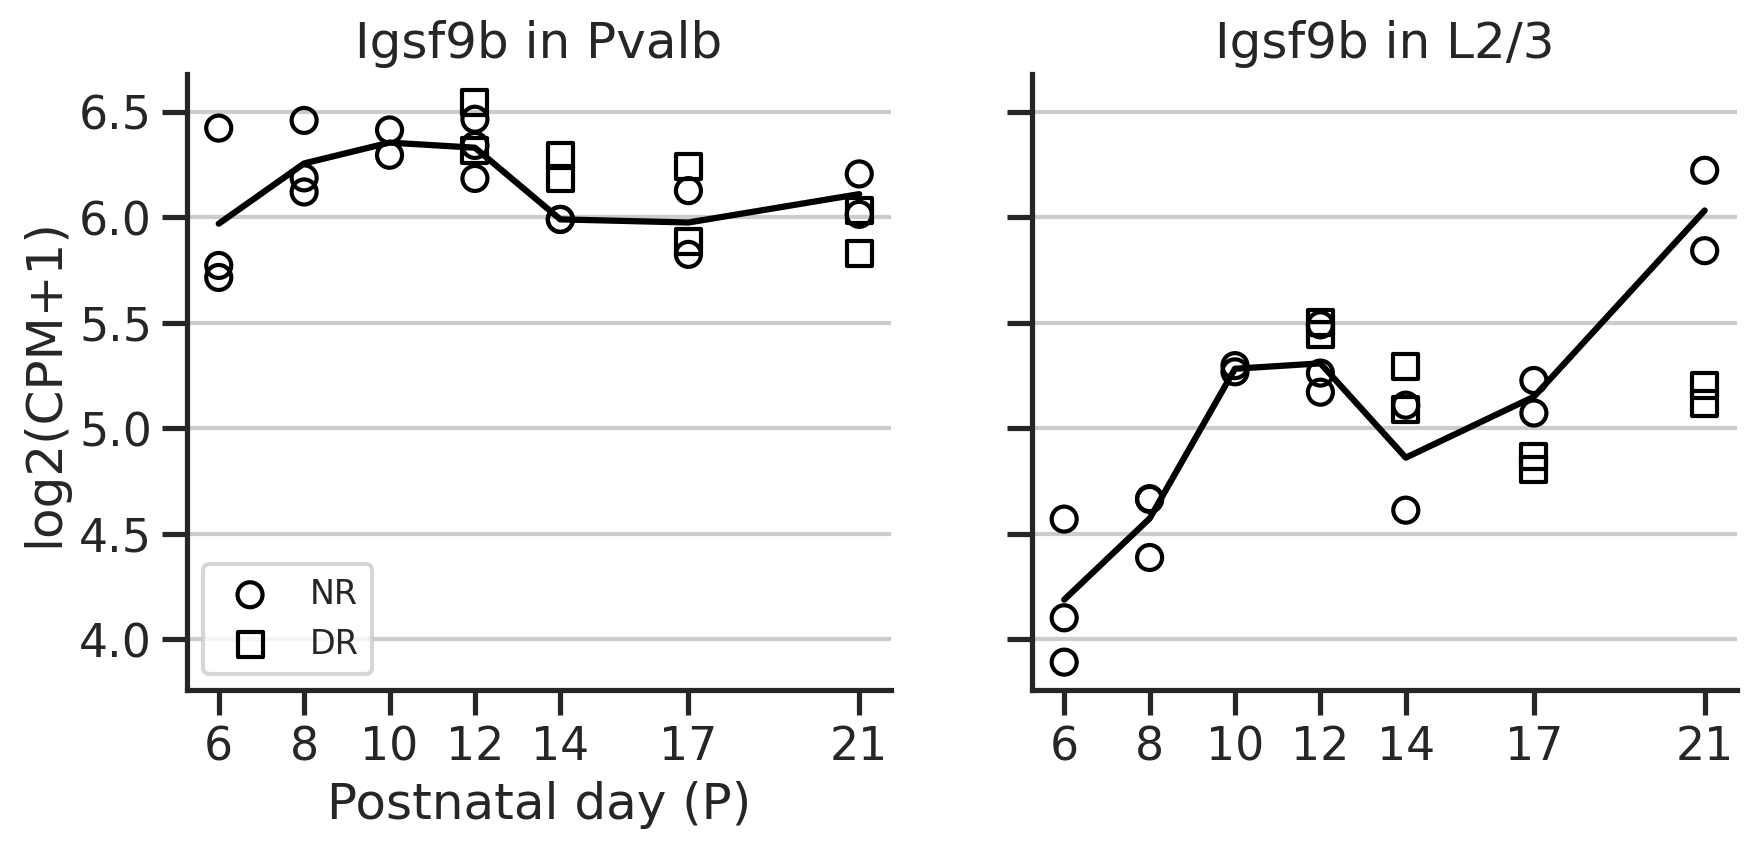

In [39]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Igsf9b')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Igsf9b', annotate=False)

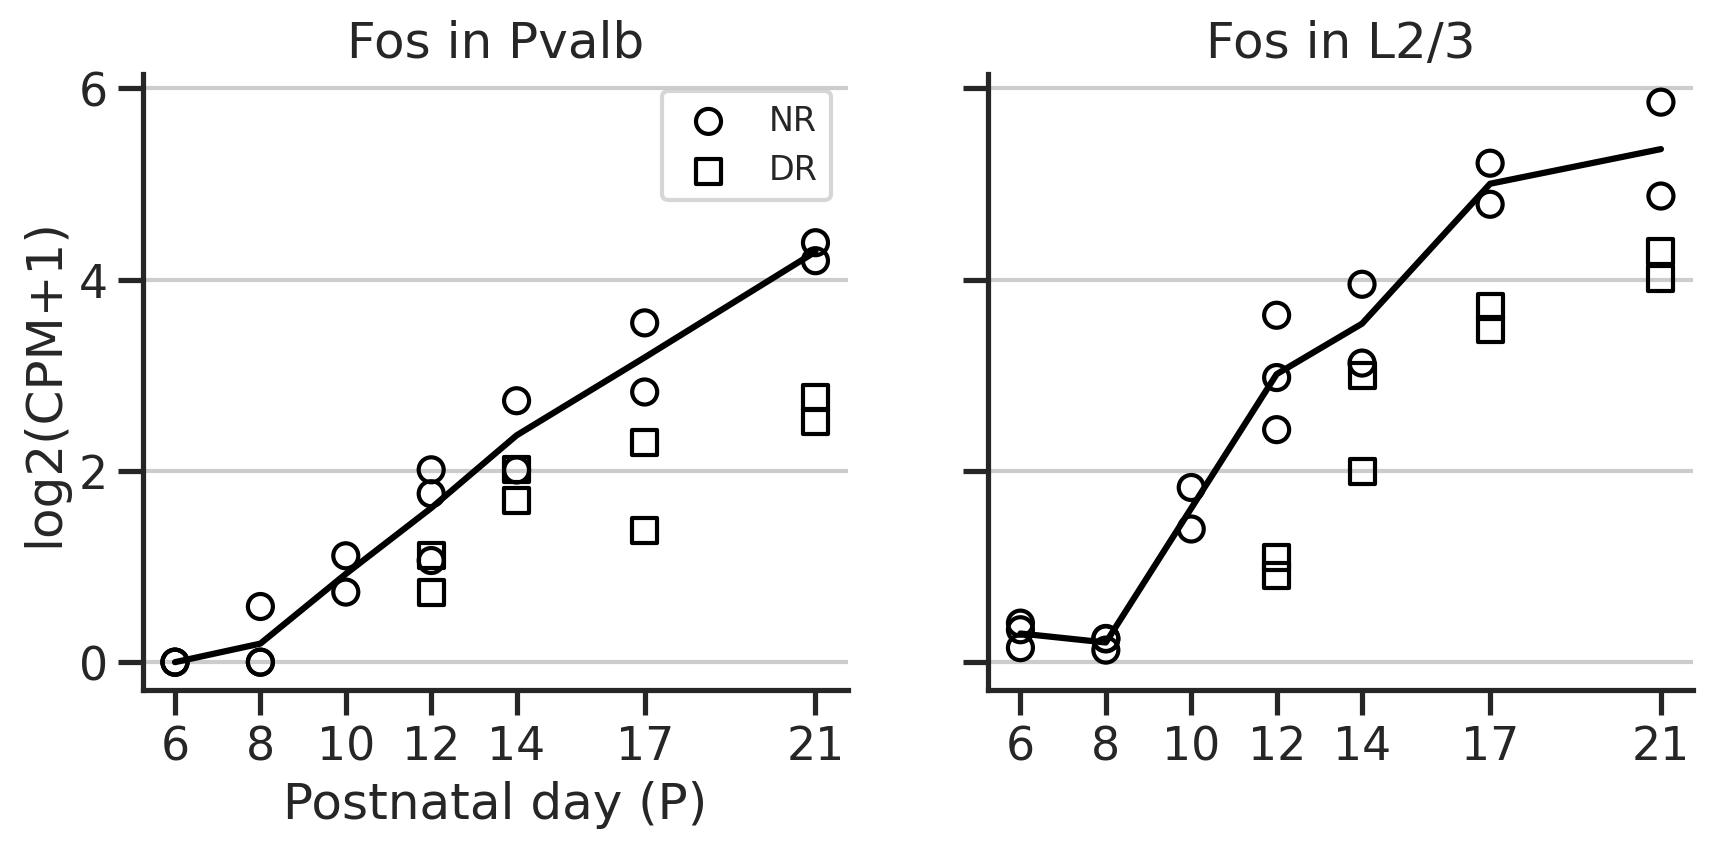

In [40]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Fos')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Fos', annotate=False)

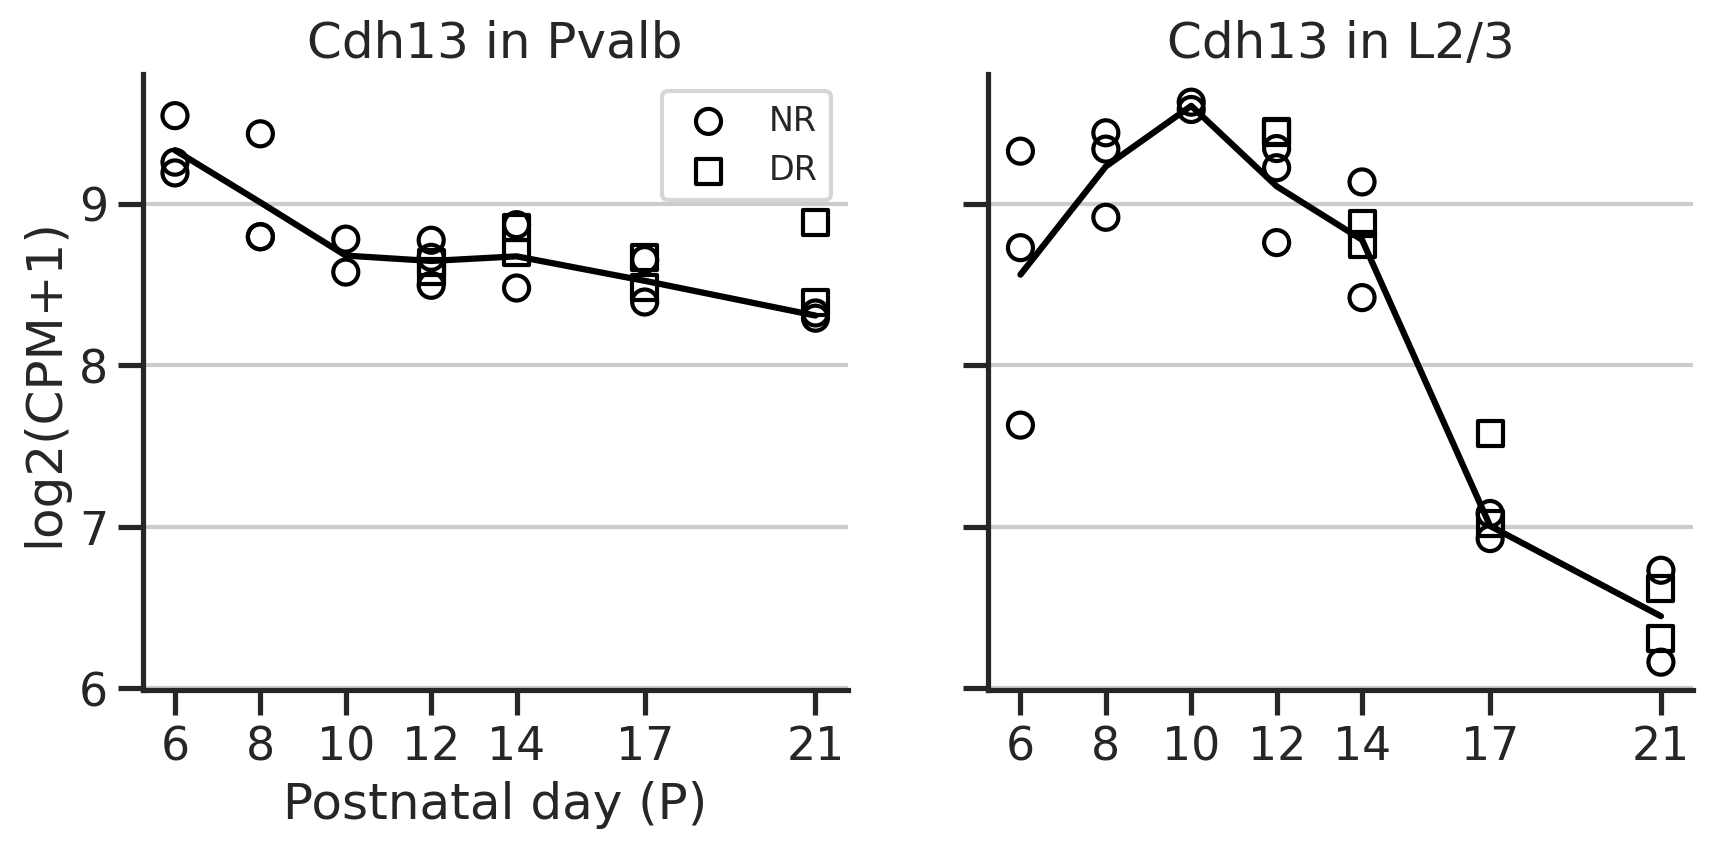

In [41]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Cdh13')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Cdh13', annotate=False)

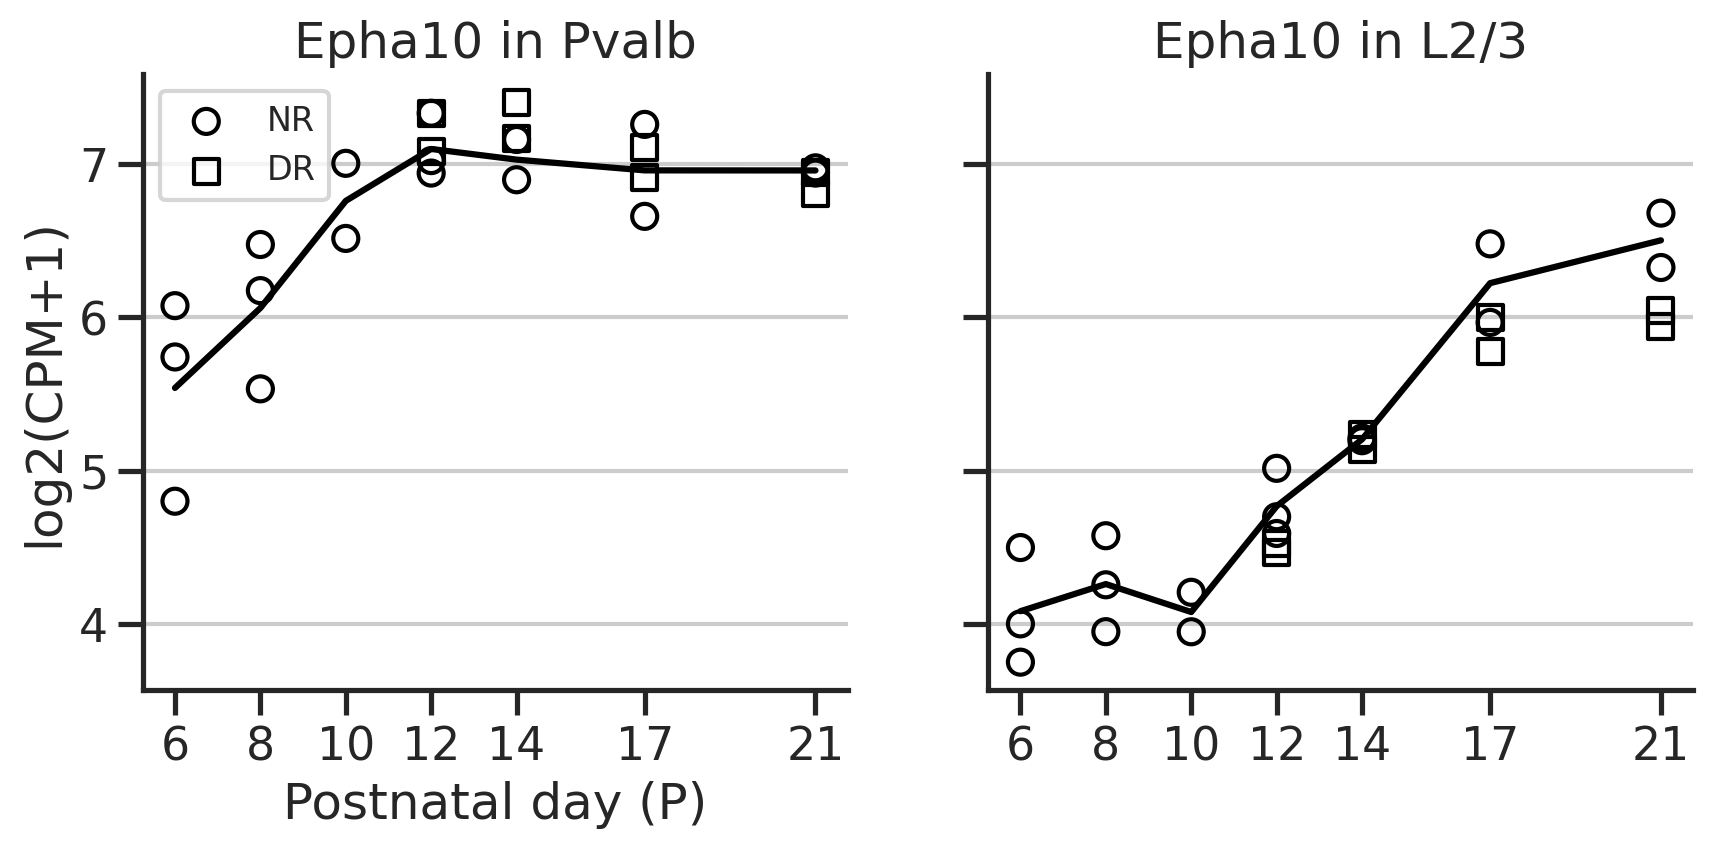

In [42]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Epha10')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Epha10', annotate=False)

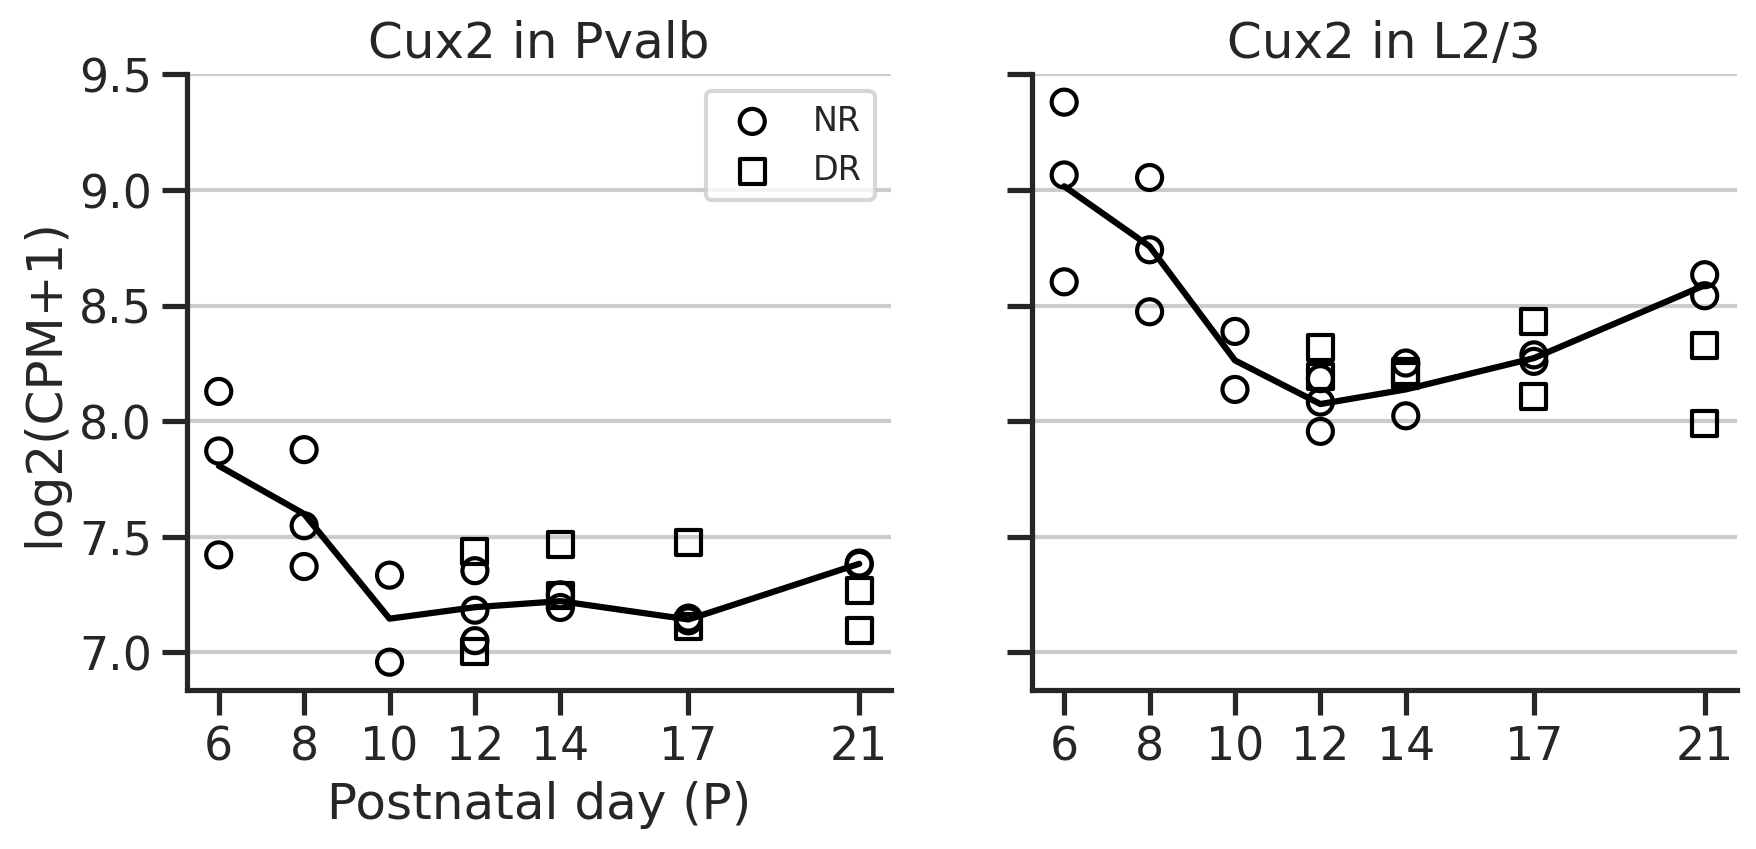

In [43]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Cux2')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Cux2', annotate=False)

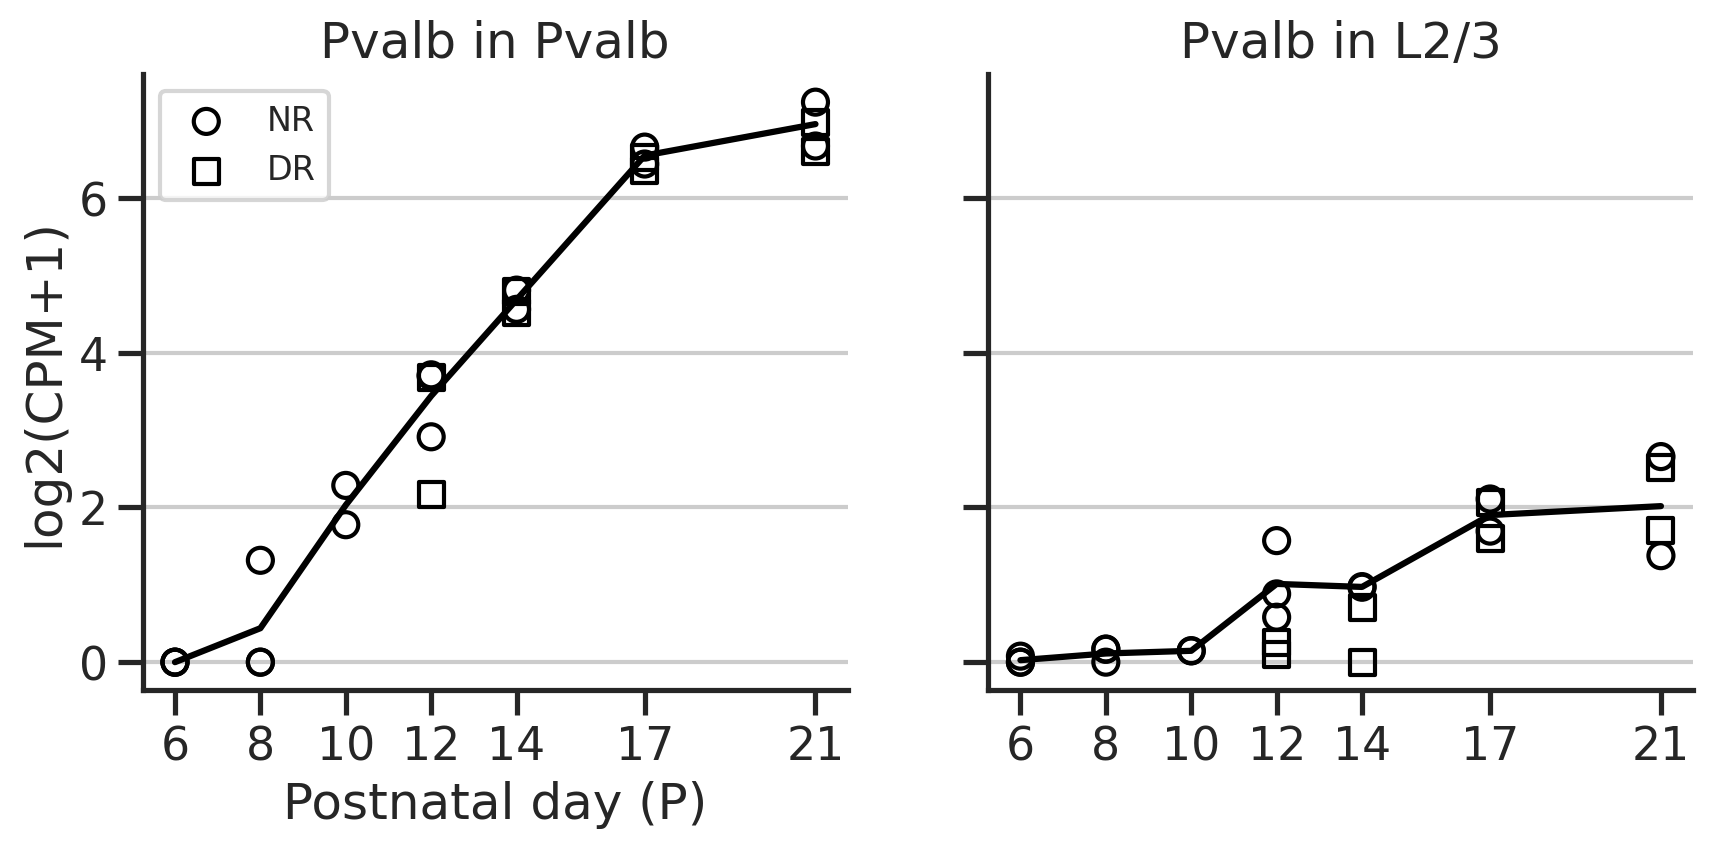

In [44]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Pvalb')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Pvalb', annotate=False)

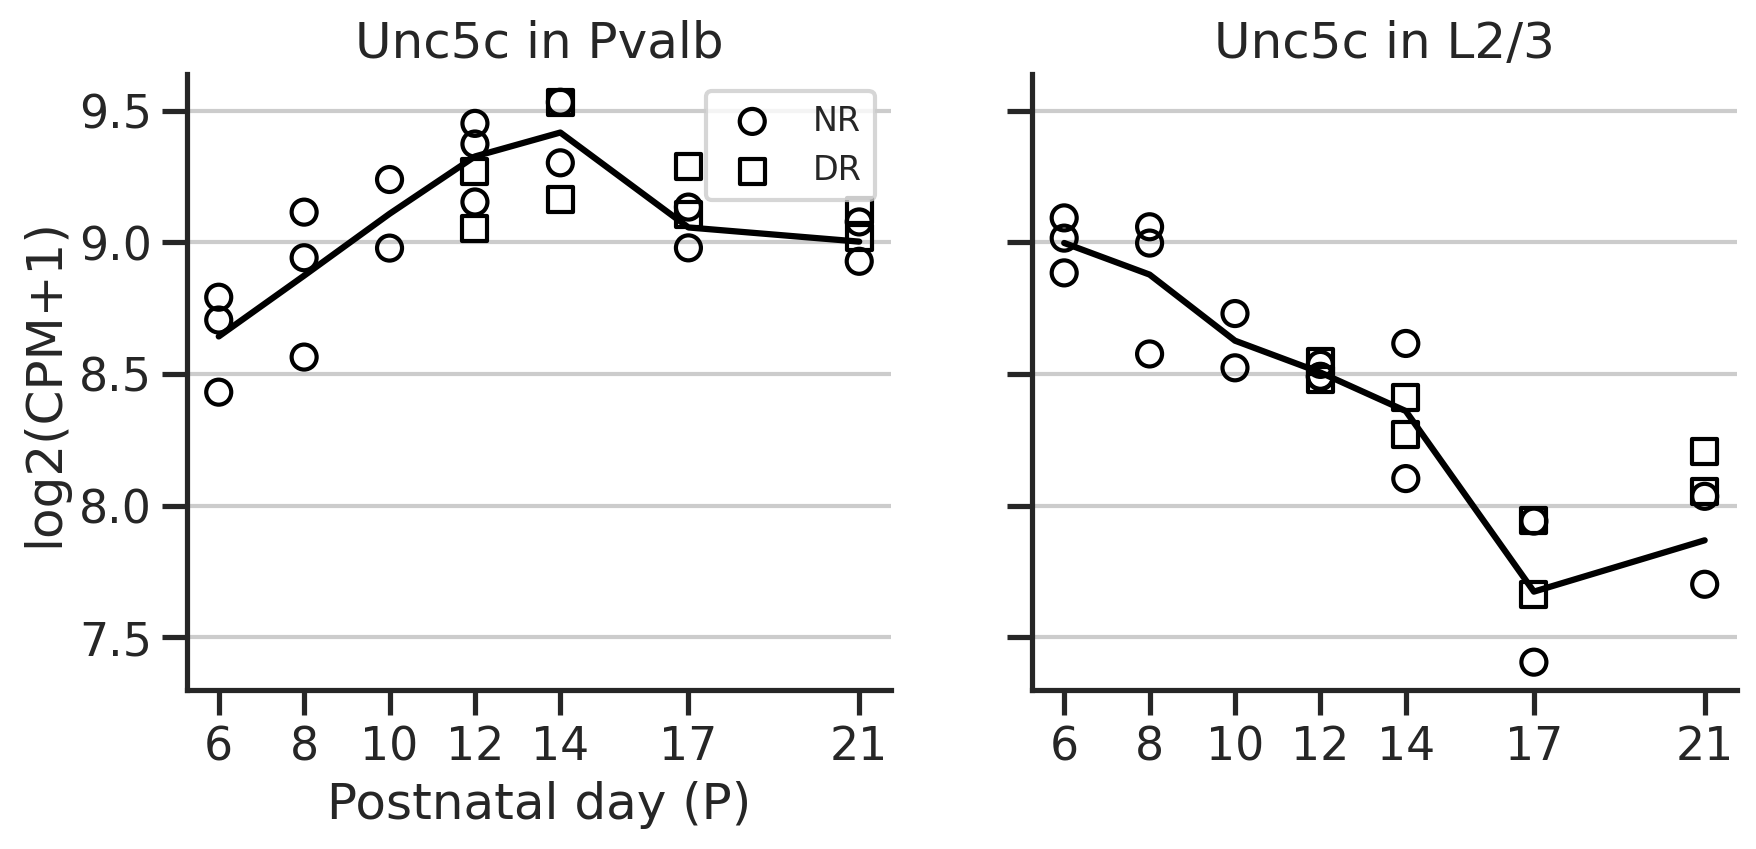

In [45]:
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'Pvalb', 'Unc5c')
ax = axs[1]
bo.plot_one(ax, 'L2/3', 'Unc5c', annotate=False)